In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import pprint
import random
import math

import networkx as nx

### Reading data frames into dictionary

In [2]:
def reading_filenames(input_dir):
    files = [f for f in os.listdir(input_dir) if f.endswith('.tsv') or f.endswith('.txt')]

    return files

In [3]:
data_folder = 'data/wikispeedia_paths-and-graph/'
file_names = reading_filenames(data_folder)

In [4]:
dataframes = {}

#Reading files in dictionary
for file in file_names:
    try:
        if file.endswith('.tsv'):
            df = pd.read_csv(data_folder + file, sep='\t', comment='#', header = None, encoding="utf-8")
        else:
            df = pd.read_csv(data_folder + file, sep=',', comment='#', header = None, encoding="utf-8")
        
        dataframes[file.split('.')[0]] = df
    except pd.errors.ParserError as e:
        print(f"Could not parse {file}: {e}")

In [5]:
dataframes['links'] = dataframes['links'].rename(columns={0: "linkSource", 1: "linkTarget"})

In [6]:
dataframes["links"]["linkSource"] = dataframes["links"]["linkSource"].apply(unquote)
dataframes["links"]["linkTarget"] = dataframes["links"]["linkTarget"].apply(unquote)

In [7]:
dataframes['links'].head(10)

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
5,Áedán_mac_Gabráin,Isle_of_Man
6,Áedán_mac_Gabráin,Monarchy
7,Áedán_mac_Gabráin,Orkney
8,Áedán_mac_Gabráin,Picts
9,Áedán_mac_Gabráin,Scotland


In [8]:
#Renaming columns
dataframes['categories'] = dataframes['categories'].rename(columns={0: "article", 1: "category"})

In [9]:
#Decoding article names
dataframes["categories"]["article"] = dataframes["categories"]["article"].apply(unquote)

In [10]:
#Splitting categories into sub categories
split_columns = dataframes["categories"]['category'].str.split('.', expand=True)

#Dropping first column which only contains the word subject
split_columns = split_columns.drop(0, axis=1)
split_columns.head()


,1,2,3
0,History,British_History,British_History_1500_and_before_including_Roma...
1,People,Historical_figures,None
2,Countries,None,None
3,Geography,European_Geography,European_Countries
4,People,Artists,None


In [11]:
#Joining with original dataframe
dataframes["categories"] = dataframes["categories"].join(split_columns)

In [12]:
dataframes['articles'] = dataframes['articles'].rename(columns={0: "article"})
dataframes["articles"]["article"] = dataframes["articles"]["article"].apply(unquote)

In [13]:
dataframes['articles'].head(10)


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts
5,€2_commemorative_coins
6,10th_century
7,11th_century
8,12th_century
9,13th_century


In [35]:
from preprocessing import WikispeediaData
data = WikispeediaData()


In [37]:
data.categories

,article_name,1st cat,2nd cat,3rd cat
0,Áedán mac Gabráin,History,British History,British History 1500 and before including Roma...
1,Áedán mac Gabráin,People,Historical figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European Geography,European Countries
4,Édouard Manet,People,Artists,None
...,...,...,...,...
5199,Zirconium,Science,Chemistry,Chemical elements
5200,Zoroaster,People,Religious figures and leaders,None
5201,Zuid-Gelders,Geography,European Geography,None
5202,Zuid-Gelders,Language and literature,Languages,None


In [25]:
G = nx.from_pandas_edgelist(data.links, source='1st article', target='2nd article')

### Create clustered graph

/home/viktor/anaconda3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


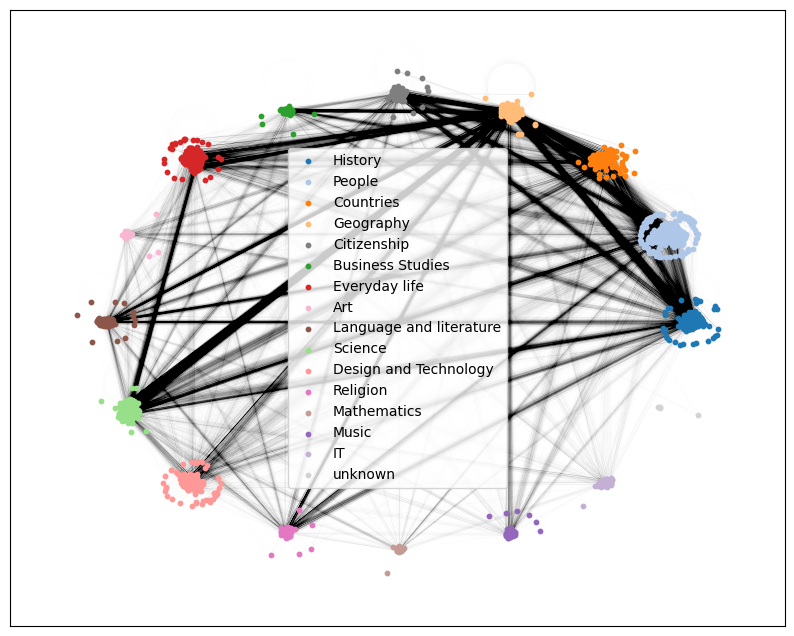

In [44]:
#Note: Make so that articles with several subjects have a special color??
color_map = {category: color for category, color in zip(data.categories['1st cat'].unique(), plt.cm.tab20.colors)}

for node in G.nodes:

    result = data.categories[data.categories['article_name'] == node]['1st cat']

    if not result.empty:
        category = result.values[0]  # Get the first category value
        G.nodes[node]['color'] = color_map.get(category, "grey")
        G.nodes[node]['category'] = category
    else:   
        G.nodes[node]['color'] = "lightgrey"
        G.nodes[node]['category'] = "unknown"


# Cluster nodes based on category
clusters = {}
for node, attr in G.nodes(data=True):
    category = attr['category']
    if category not in clusters:
        clusters[category] = []
    clusters[category].append(node)


positions = {}
r = 10 

# Places all clusters in a circle
for index, (category, nodes) in enumerate(clusters.items()):
    # Creates a subgraph for each category and positions them using spring_layput
    subG = G.subgraph(nodes)
    sub_positions = nx.spring_layout(subG, seed=1, k=0.1)

    # Displaces all nodes in subG on a circle around the origin
    angle = (2 * math.pi * index) / len(clusters)
    x = r * math.cos(angle)
    y = r * math.sin(angle)

    for node in sub_positions:
        positions[node] = [sub_positions[node][0] + x, sub_positions[node][1] + y]
    
# Draws a plot clustered by category
plt.figure(figsize=(10, 8))

for category, nodes in clusters.items():
    nx.draw_networkx_nodes(G, pos=positions, 
                           node_size=10, 
                           nodelist=nodes, 
                           node_color=G.nodes[nodes[0]]['color'], 
                           label=category)
    
nx.draw_networkx_edges(G, positions, alpha=0.2, width=0.01)
plt.legend()
plt.show()




In [48]:
data.links

,1st article,2nd article,different_cat
0,Áedán mac Gabráin,Bede,0.0
1,Áedán mac Gabráin,Columba,1.0
2,Áedán mac Gabráin,Dál Riata,0.0
3,Áedán mac Gabráin,Great Britain,0.0
4,Áedán mac Gabráin,Ireland,1.0
...,...,...,...
119877,Zulu,South Africa,0.0
119878,Zulu,Swaziland,0.0
119879,Zulu,United Kingdom,1.0
119880,Zulu,Zambia,0.0


### Create summarized graph (Not Done)

In [52]:
#Note: Make so that articles with several subjects have a special color??
color_map = {category: color for category, color in zip(data.categories['1st cat'].unique(), plt.cm.tab20.colors)}

# Calculates the amount of articles in all cateogies
node_nr = data.categories['1st cat'].value_counts()

# Adds the categories of Source and Target to the links data via merging twice 
links_nr = data.links.merge(right=data.categories[['article_name', '1st cat']], 
                                     left_on='1st article', 
                                     right_on = 'article_name', 
                                     how='left')

links_nr = links_nr.merge(right=data.categories[['article_name', '1st cat']], 
                          left_on='2nd article', 
                          right_on = 'article_name', 
                          how='left')

links_nr

# Drops duplicate rows
links_nr = links_nr.drop_duplicates(ignore_index=True).rename(columns={'1st cat_x': "Category 1st article",
                                                                       '1st cat_y': "Category 2nd article"})

# Replaces all NaN values with 'unknown', so to not lose in value_count()
links_nr = links_nr.fillna('unknown')

# Checks that nothing has been lost
# print(links_nr.shape)
# links_nr.value_counts(subset=['CategorySource', 'CategoryTarget']).sum()

# Gives the amount of connections between all categories
links_nr = links_nr.value_counts(subset=['Category 1st article', 'Category 2nd article']).reset_index(name='counts')

# Only keeps the pairs with over 500 links
# links_nr = links_nr[links_nr['counts'] >= 1000]



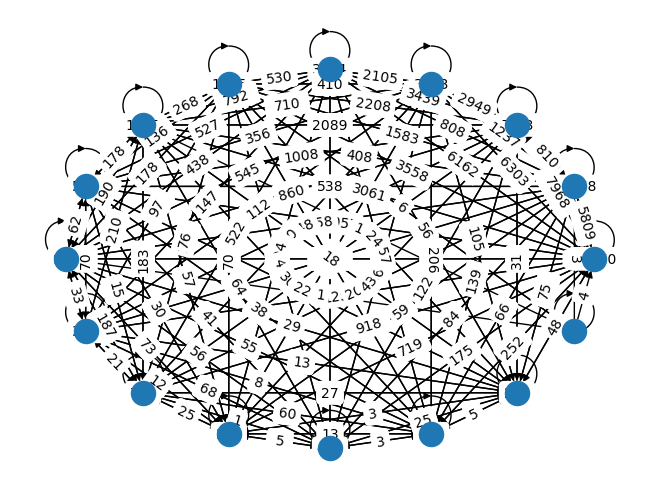

In [54]:
G = nx.DiGraph()

for index, row in links_nr.iterrows():
    G.add_edge(row['Category 1st article'], row['Category 2nd article'], weight=row['counts'])

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=False)
nx.draw_networkx_edge_labels(G, pos, edge_labels= nx.get_edge_attributes(G, 'weight'))

plt.show()



### Calculate shortest paths

In [ ]:
from itertools import product
pairs = list(product(data.articles['article_name'], repeat=2))



In [121]:
data.paths_finished

,hashedIpAddress,timestamp,durationInSec,path,rating,paths
0,6a3701d319fc3754,1297740409,166,"[14th century, 15th century, 16th century, Pac...",NaN,"[14th century, 15th century, 16th century, Pac..."
1,3824310e536af032,1344753412,88,"[14th century, Europe, Africa, Atlantic slave ...",3.0,"[14th century, Europe, Africa, Atlantic slave ..."
2,415612e93584d30e,1349298640,138,"[14th century, Niger, Nigeria, British Empire,...",NaN,"[14th century, Niger, Nigeria, British Empire,..."
3,64dd5cd342e3780c,1265613925,37,"[14th century, Renaissance, Ancient Greece, Gr...",NaN,"[14th century, Renaissance, Ancient Greece, Gr..."
4,015245d773376aab,1366730828,175,"[14th century, Italy, Roman Catholic Church, H...",3.0,"[14th century, Italy, Roman Catholic Church, H..."
...,...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,"[Yagan, Ancient Egypt, Civilization]",NaN,"[Yagan, Ancient Egypt, Civilization]"
51314,2ef7ac844cefda58,1300254138,165,"[Yagan, Folklore, 19th century, Charles Dicken...",3.0,"[Yagan, Folklore, 19th century, Charles Dicken..."
51315,12863abb7887f890,1385095372,228,"[Yagan, Australia, England, France, United Sta...",NaN,"[Yagan, Australia, England, France, United Sta..."
51316,19f8284371753362,1298792567,56,"[Yarralumla, Australian Capital Territory, Aus...",1.0,"[Yarralumla, Australian Capital Territory, Aus..."


In [153]:
# Creates df store all paths taken in game
shortest_paths = pd.DataFrame(index= range(data.paths_finished.shape[0] + data.paths_unfinished.shape[0]), 
                              columns=['source', 'target'])

# Adds source and target for all finished paths
for index, row in data.paths_finished.iterrows():
    source = row['path'][0]
    target = row['path'][-1]
    shortest_paths.at[index, 'source'] =  source
    shortest_paths.at[index, 'target'] = target

#Adds source and target for all unfinished paths
for index, row in data.paths_unfinished.iterrows():
    index = index + data.paths_finished.shape[0]
    source = row['path'][0]
    target = row['target']
    shortest_paths.at[index, 'source'] =  source
    shortest_paths.at[index, 'target'] = target


In [112]:
# Loads the shortest paths distances
shortest_distance = data.load_shortest_paths()

In [113]:
data.links

,1st article,2nd article,different_cat
0,Áedán mac Gabráin,Bede,0.0
1,Áedán mac Gabráin,Columba,1.0
2,Áedán mac Gabráin,Dál Riata,0.0
3,Áedán mac Gabráin,Great Britain,0.0
4,Áedán mac Gabráin,Ireland,1.0
...,...,...,...
119877,Zulu,South Africa,0.0
119878,Zulu,Swaziland,0.0
119879,Zulu,United Kingdom,1.0
119880,Zulu,Zambia,0.0


In [ ]:
# Creates directed graph between all articles 
G = nx.from_pandas_edgelist(data.links, 
                            source='1st article', 
                            target='2nd article',
                            create_using=nx.DiGraph())


# Adds new column to shortest_paths, to keep all paths
shortest_paths['shortest_paths'] = None

# Initiate list indecies causing bugs
bugIndecies = []

# Calculates all possible shortest paths for all games and saves them in datarame "shortest_paths"
for index, row in shortest_paths.iterrows():
    if index == 100:
        break
    try:
        paths = list(nx.all_shortest_paths(G, source=row['source'], target=row['target']))
        # paths = nx.shortest_path(G, source=row['source'], target=row['target'])
        shortest_paths.at[index, 'shortest_paths'] = paths
    except nx.NetworkXNoPath:   # If no path exists
        bugIndecies.append(index)
    except nx.NodeNotFound:     # If node not found
        bugIndecies.append(index)

# Removes all games causing bugs in code
shortest_paths = shortest_paths.drop(index=bugIndecies)

# Saves down results in a csv
shortest_paths['shortest_paths'].to_csv("shortest_paths.csv", index=False)


# Most of the errors are due to misspellings of targits in data.paths_unfinished, but also some
# other errors, such as links that dont exist (but should) or NoPathsFound


In [162]:
len(bugIndecies)

37